# Test notebook - develop study of the results


In [2]:
import sys
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from earlyrnn import EarlyRNN
import torch
from loss import EarlyRewardLoss
import pandas as pd
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times
from utils.doy import get_doys_dict_test, get_doy_stop
from utils.helpers_training import parse_args
from utils.helpers_testing import test_dataset, get_test_stats
import matplotlib.pyplot as plt

In [9]:
import argparse

def parse_args(args=None):
    parser = argparse.ArgumentParser(description='Run ELECTS Early Classification training on the BavarianCrops dataset.')
    parser.add_argument('--dataset', type=str, default="bavariancrops", choices=["bavariancrops","breizhcrops", "ghana", "southsudan","unitedstates"], help="dataset")
    parser.add_argument('--alpha', type=float, default=0.5, help="trade-off parameter of earliness and accuracy (eq 6): "
                                                                 "1=full weight on accuracy; 0=full weight on earliness")
    parser.add_argument('--epsilon', type=float, default=10, help="additive smoothing parameter that helps the "
                                                                  "model recover from too early classifications (eq 7)")
    parser.add_argument('--learning-rate', type=float, default=1e-3, help="Optimizer learning rate")
    parser.add_argument('--weight-decay', type=float, default=0, help="weight_decay")
    parser.add_argument('--patience', type=int, default=30, help="Early stopping patience")
    parser.add_argument('--device', type=str, default="cuda" if torch.cuda.is_available() else "cpu",
                        choices=["cuda", "cpu"], help="'cuda' (GPU) or 'cpu' device to run the code. "
                                                     "defaults to 'cuda' if GPU is available, otherwise 'cpu'")
    parser.add_argument('--epochs', type=int, default=100, help="number of training epochs")
    parser.add_argument('--sequencelength', type=int, default=70, help="sequencelength of the time series. If samples are shorter, "
                                                                "they are zero-padded until this length; "
                                                                "if samples are longer, they will be undersampled")
    parser.add_argument('--hidden-dims', type=int, default=64, help="number of hidden dimensions in the backbone model")
    parser.add_argument('--batchsize', type=int, default=256, help="number of samples per batch")
    parser.add_argument('--dataroot', type=str, default=os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data"), help="directory to download the "
                                                                                 "BavarianCrops dataset (400MB)."
                                                                                 "Defaults to home directory.")
    parser.add_argument('--snapshot', type=str, default="snapshots/model.pth",
                        help="pytorch state dict snapshot file")
    parser.add_argument('--resume', action='store_true')

    if args is not None:
        args = parser.parse_args(args)
    else:
        args = parser.parse_args()

    if args.patience < 0:
        args.patience = None

    return args

custom_args = "--dataset breizhcrops --snapshot ./models/breizhcrops_models/elects_lstm/model.pth --sequencelength 150".split()
args = parse_args(custom_args)
print("cuda is available: ", args.device)
print(args)

cuda is available:  cuda
Namespace(dataset='breizhcrops', alpha=0.5, epsilon=10, learning_rate=0.001, weight_decay=0, patience=30, device='cuda', epochs=100, sequencelength=150, hidden_dims=64, batchsize=256, dataroot='C:\\Users\\anyam\\elects_data', snapshot='./models/breizhcrops_models/elects_lstm/model.pth', resume=False)


## Test.py - Test the model


In [5]:
# ----------------------------- LOAD DATASET -----------------------------
if args.dataset == "breizhcrops":
    dataroot = os.path.join(args.dataroot,"breizhcrops")
    nclasses = 9
    input_dim = 13
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    test_ds = BreizhCrops(root=dataroot,partition="eval", sequencelength=args.sequencelength, return_id=True)
    class_names = test_ds.ds.classname
    print("class names:", class_names)
else:
    raise ValueError(f"dataset {args.dataset} not recognized")


1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [00:57<00:00, 2129.94it/s]

class names: ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


Extracting labels from dataset Test.


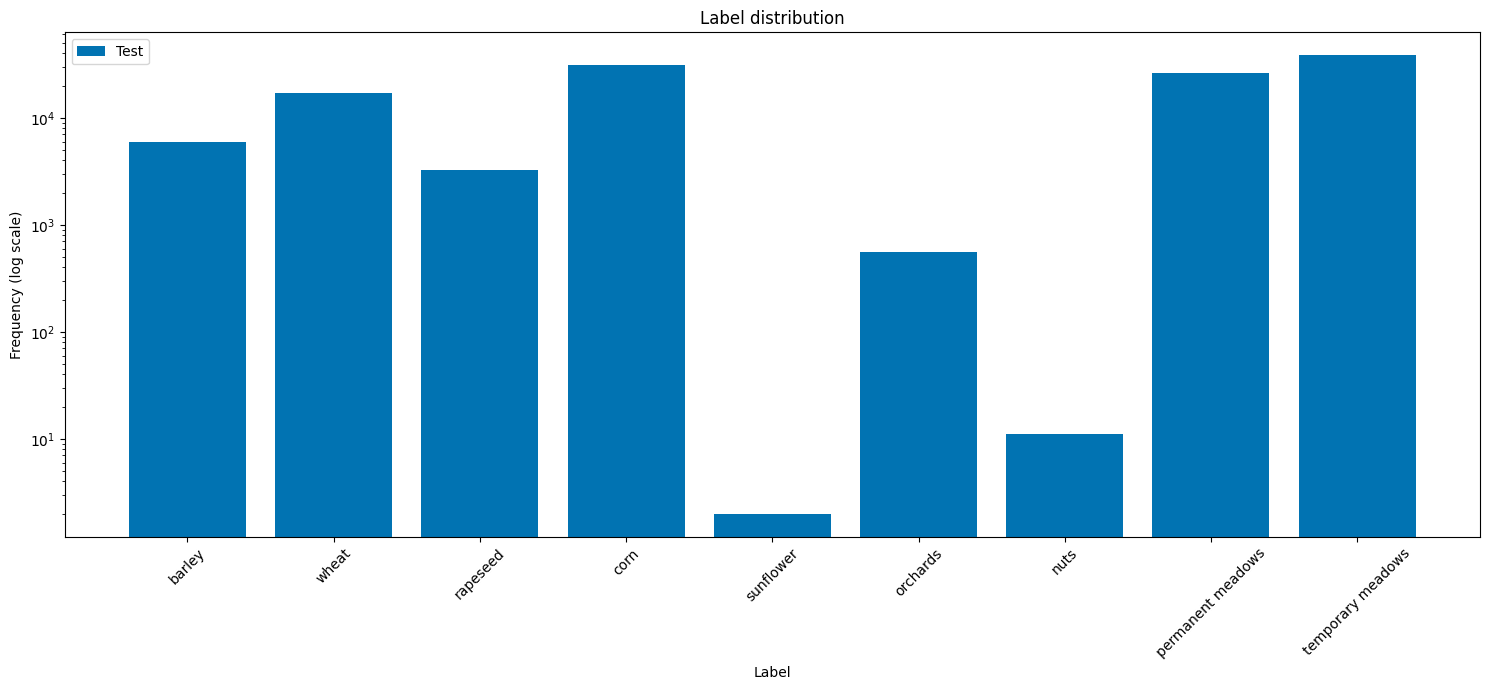

In [6]:
# take about 1 minute
# ----------------------------- VISUALIZATION: label distribution -----------------------------
datasets = [test_ds]
sets_labels = ["Test"]
fig, ax = plt.subplots(figsize=(15, 7))
fig, ax = plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=class_names)

In [10]:
# ----------------------------- LOAD MODEL -----------------------------
model = EarlyRNN(nclasses=nclasses, input_dim=input_dim, hidden_dims=args.hidden_dims, sequencelength=args.sequencelength).to(args.device)
model.load_state_dict(torch.load(args.snapshot))
print("model loaded from", args.snapshot) 
criterion = EarlyRewardLoss(alpha=args.alpha, epsilon=args.epsilon)


model loaded from ./models/breizhcrops_models/elects_lstm/model.pth


In [11]:
# ----------------------------- TEST -----------------------------
testloss, stats = test_dataset(model, test_ds, criterion, args.device, args.batchsize)
test_stats = get_test_stats(stats, testloss, args)


  0%|          | 0/479 [00:00<?, ?it/s]

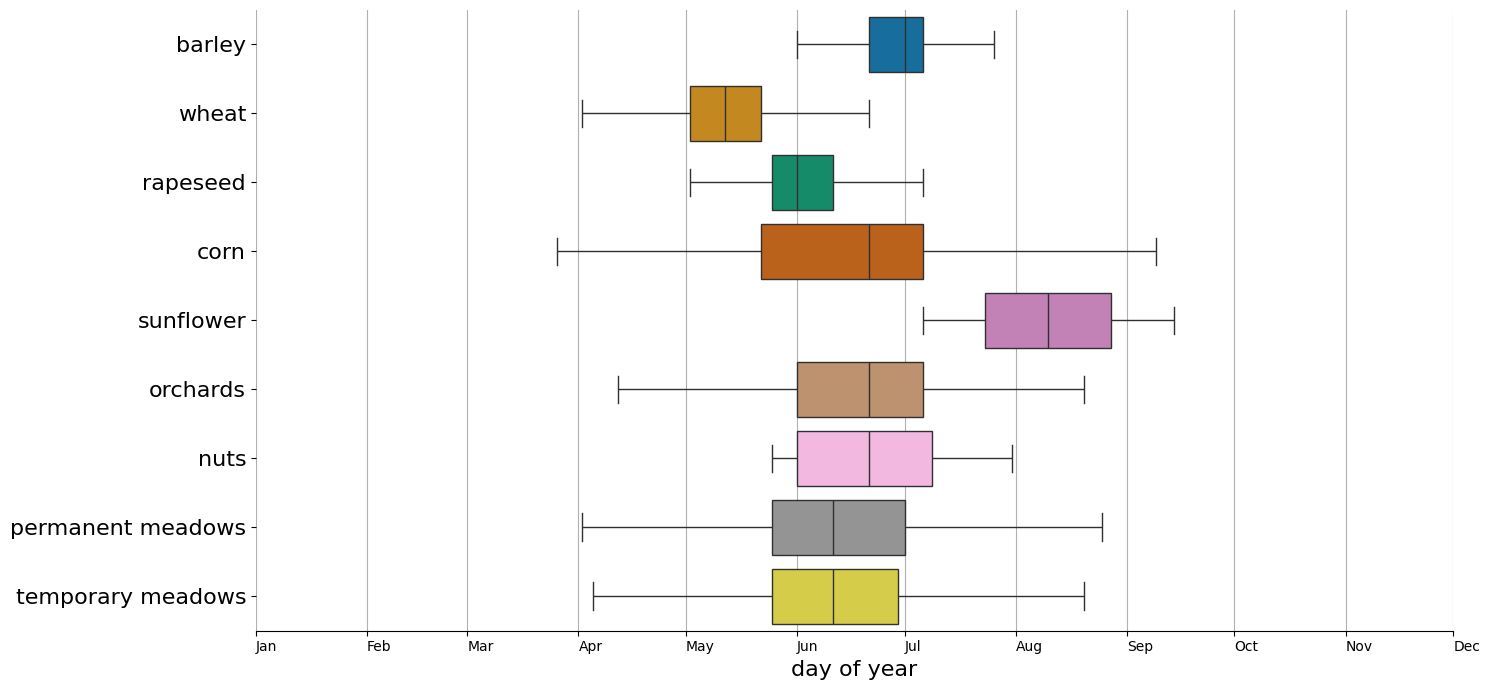

In [13]:
# ----------------------------- VISUALIZATION: stopping times -----------------------------
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
doys_stop = get_doy_stop(stats, doys_dict_test, approximated=False)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)

In [31]:
import datetime
import seaborn


def add_doys_lines(ax, dates_of_interest:list=["2017-05-01", "2017-06-01","2017-07-01","2017-08-01","2017-09-01"], ymax=1.1, ymin=0.):
    doys_of_interest = [datetime.datetime.strptime(d,"%Y-%m-%d").timetuple().tm_yday for d in dates_of_interest]
    for d, date in zip(doys_of_interest, dates_of_interest):
        ax.axvline(d, color="gray", ymin=ymin, ymax=ymax, linestyle="--")
        ax.text(d, ymax, date.replace("2017-0",""), ha="center", fontsize=8)
        
def plot(doys, class_probabilities, stop_probabilities):
    fig, axs = plt.subplots(2,1, figsize=(6,4), sharex=True)
    seaborn.despine()
    ax = axs[0]
    ax.plot(doys, class_probabilities)
    #ax.set_xlabel("day of year")
    ax.set_ylabel("class score")
    add_doys_lines(ax)

    ax = axs[1]
    ax.plot(doys, stop_probabilities)
    ax.set_xlabel("day of year")
    ax.set_ylabel("stopping probability")
    add_doys_lines(ax)
    
def plot_id(id, stats, doys_dict, model, device):
    idx = list(stats["ids"][:,0]).index(id)

    X,y, id = test_ds[idx]
    doys = doys_dict[id]

    t_stop = stats["t_stop"][idx,0]
    doy_stop = doys[t_stop]
    date_stop = datetime.datetime(2017,1,1) + datetime.timedelta(days=int(doy_stop-1))

    msk = X[:,0]>0
    X = X[msk]
    X = X.unsqueeze(0).to(device)
    log_class_probabilities, probability_stopping = model(X)

    class_probabilities = log_class_probabilities[0].cpu().detach().exp()
    stop_probabilities = probability_stopping[0].cpu().detach()

    plot(doys, class_probabilities, stop_probabilities)
    print(id)
    y = stats["targets"][idx,0]
    print(f"class {y}")

    pred = stats["predictions_at_t_stop"][idx,0]
    print(f"pred {pred}")

    print(t_stop, doy_stop, date_stop)

6052609
class 2
pred 2
29 152 2017-06-01 00:00:00


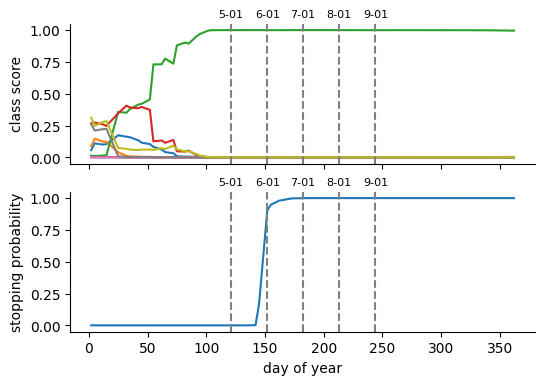

In [32]:
plot_id(6052609, stats, doys_dict_test, model, args.device)


In [68]:
print(stats.keys())
print("doys_stop:", doys_stop)
doys = [doys_dict_test[id] for id in stats["ids"][:,0]]
print(len(doys))
print(len(doys[0]))

dict_keys(['classification_loss', 'earliness_reward', 'probability_making_decision', 'loss', 'probability_stopping', 'class_probabilities', 'predictions_at_t_stop', 't_stop', 'targets', 'ids', 'seqlengths', 'classification_earliness'])
doys_stop: [182 212 187 ... 357 197 232]
122614
102


Problem: different lengths of the sequences. Need to interpolate to the same length, and the calculate the mean and the std at a certain date per class. 

prob. making decision shape: (122614, 150)
predicted class shape: (122614,)


ValueError: List of boxplot statistics and `positions` values must have same the length

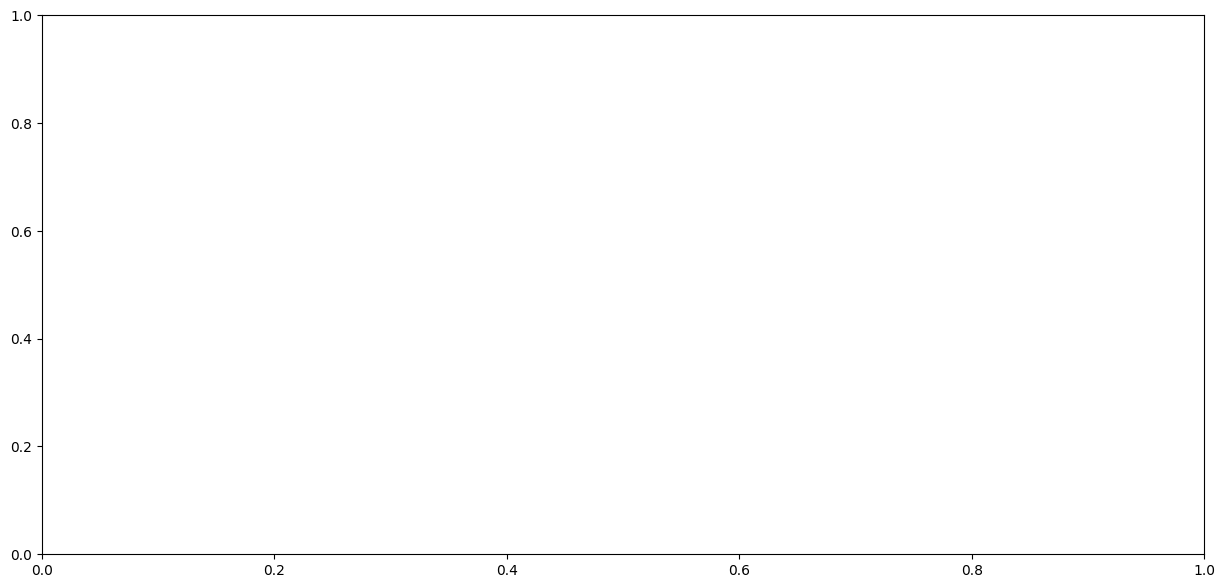

In [66]:
fig, ax = plt.subplots(figsize=(15, 7))
probability_making_decision = stats["probability_making_decision"]

predicted_class = stats["targets"][:,0]
print("prob. making decision shape:", probability_making_decision.shape)
print("predicted class shape:", predicted_class.shape)
doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13)]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]



## Visualisation of the results

### Save the results

In [ ]:
# ----------------------------- SAVE -----------------------------
fig.savefig(os.path.join(os.path.dirname(args.snapshot), "label_distribution.png"), bbox_inches='tight')
fig_boxplot.savefig(os.path.join(os.path.dirname(args.snapshot), "stopping_times.png"), bbox_inches='tight')
test_stats_df = pd.DataFrame(test_stats, index=[0])
test_stats_df.to_csv(os.path.join(os.path.dirname(args.snapshot), "test_stats.csv"))
plt.show()

## Temporal masking